<a href="https://colab.research.google.com/github/tr41z/machine-learning/blob/main/AI_RAD_SL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 **Threat Detection using UNSW-NB15 Dataset** 🔐

In this notebook, I’ll be building an **threat detection model** using the **UNSW-NB15 dataset**. The main objective is to detect unusual or unexpected patterns in network traffic that could represent potential security threats.

### 🛠️ **Tools and Libraries I'll Use:**
- **Python** for data preprocessing and model building.
- **scikit-learn** and optionally **TensorFlow/PyTorch** for machine learning algorithms to identify anomalies.
- **Pandas** and **NumPy** for data manipulation and processing.
- **Matplotlib** and **Seaborn** for visualizing the data and results.

### 📊 **Dataset Overview:**
The **UNSW-NB15** dataset includes both normal and abnormal network traffic, making it ideal for threat detection. I'll be working with:
- **49 features** that describe various aspects of network traffic.
- A combination of normal and anomalous traffic data, allowing the model to learn the difference between the two.

By the end of this notebook, I'll have trained and evaluated a machine learning model that can detect anomalies in network traffic, which could be used for tasks like intrusion detection or identifying unusual network activity.

In [1]:
!nvidia-smi

Wed Nov  6 09:54:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 🧸 Getting familiar with data

### 📦 **Importing Necessary Libraries**

> In this section, I’m importing the libraries that will be used for `data manipulation`, `visualization`, `preprocessing`, and `machine learning`.


In [2]:
!pip install dtreeviz catboost dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 7.0 MB/s eta 0:00:00


In [3]:
# Data manipulation
import pandas as pd
import numpy as np
import logging

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

# Data encoding, preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
import plotly.express as px

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    BaggingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### 🫙 Mounting google drive to get data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 📚 Reading data and visualising, analysing it

In [5]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/UNSW-NB15/CSV/UNSW_NB15_training-set.csv'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/UNSW-NB15/CSV/UNSW_NB15_testing-set.csv'

train_data = pd.read_csv(train_dir)
test_data = pd.read_csv(test_dir)

In [6]:
df = pd.concat([train_data,test_data]).drop('id',axis=1)
df = df.reset_index(drop=True)

df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


# 💡 Data Preprocessing

In [7]:
df['state'].unique()

array(['FIN', 'INT', 'CON', 'ECO', 'REQ', 'RST', 'PAR', 'URN', 'no',
       'ACC', 'CLO'], dtype=object)

In [8]:
# Convert 'state' column to categorical type and store the original categories
df['state'] = df['state'].astype('category')
original_states = df['state'].cat.categories.tolist()  # Store original categories

In [9]:
for col in ['proto', 'service', 'state']:
    df[col] = df[col].astype('category').cat.codes

df['state'] = df['state'].replace(10, -1)
df['attack_cat'] = df['attack_cat'].astype('category')

In [10]:
df['attack_cat'].unique()

['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode', 'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic']
Categories (10, object): ['Analysis', 'Backdoor', 'DoS', 'Exploits', ..., 'Normal', 'Reconnaissance',
                          'Shellcode', 'Worms']

In [11]:
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [12]:
# Filter for reconnaissance attacks
df = df[df['attack_cat'].isin(['Reconnaissance', 'Normal'])]

In [13]:
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [14]:
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106987 entries, 0 to 257672
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   dur                106987 non-null  float64 
 1   proto              106987 non-null  int16   
 2   service            106987 non-null  int8    
 3   state              106987 non-null  int8    
 4   spkts              106987 non-null  int64   
 5   dpkts              106987 non-null  int64   
 6   sbytes             106987 non-null  int64   
 7   dbytes             106987 non-null  int64   
 8   rate               106987 non-null  float64 
 9   sttl               106987 non-null  int64   
 10  dttl               106987 non-null  int64   
 11  sload              106987 non-null  float64 
 12  dload              106987 non-null  float64 
 13  sloss              106987 non-null  int64   
 14  dloss              106987 non-null  int64   
 15  sinpkt             106987 non-null  flo

In [16]:
df.describe()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,106987.000000,106987.000000,106987.000000,106987.000000,106987.000000,106987.000000,106987.000000,1.069870e+05,1.069870e+05,106987.000000,...,106987.000000,106987.000000,106987.000000,106987.000000,106987.000000,106987.000000,106987.000000,106987.000000,106987.000000,106987.000000
mean,1.014052,110.125071,1.267238,3.886855,24.879359,29.361567,3655.648789,2.295595e+04,3.006418e+04,115.562638,...,1.709039,1.156823,3.655463,0.012319,0.012394,0.143232,3.812426,5.070990,0.034378,0.130736
std,4.609451,21.287851,2.366461,1.043407,50.458725,94.892991,12356.615213,1.251715e+05,1.030706e+05,107.853951,...,2.268323,1.494351,5.328239,0.110476,0.111311,0.623935,4.058072,5.563448,0.182199,0.337112
min,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,24.000000,0.000000e+00,0.000000e+00,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.001090,113.000000,0.000000,4.000000,2.000000,2.000000,284.000000,1.780000e+02,2.616341e+01,31.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,0.056960,113.000000,0.000000,4.000000,10.000000,8.000000,850.000000,3.540000e+02,5.691376e+02,31.000000,...,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000
75%,0.769938,119.000000,2.000000,4.000000,22.000000,18.000000,2516.000000,3.380000e+03,3.983512e+03,254.000000,...,2.000000,1.000000,4.000000,0.000000,0.000000,0.000000,5.000000,6.000000,0.000000,0.000000
max,59.999989,132.000000,11.000000,9.000000,818.000000,5254.000000,339100.000000,7.085342e+06,1.000000e+06,255.000000,...,46.000000,46.000000,65.000000,2.000000,2.000000,16.000000,47.000000,62.000000,1.000000,1.000000


In [17]:
X = df.drop(columns = ['attack_cat', 'label'])
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((74890, 42), (74890,), (32097, 42), (32097,))

### 🖊️ Visualising some data

attack_cat
Normal            93000
Reconnaissance    13987
Name: count, dtype: int64


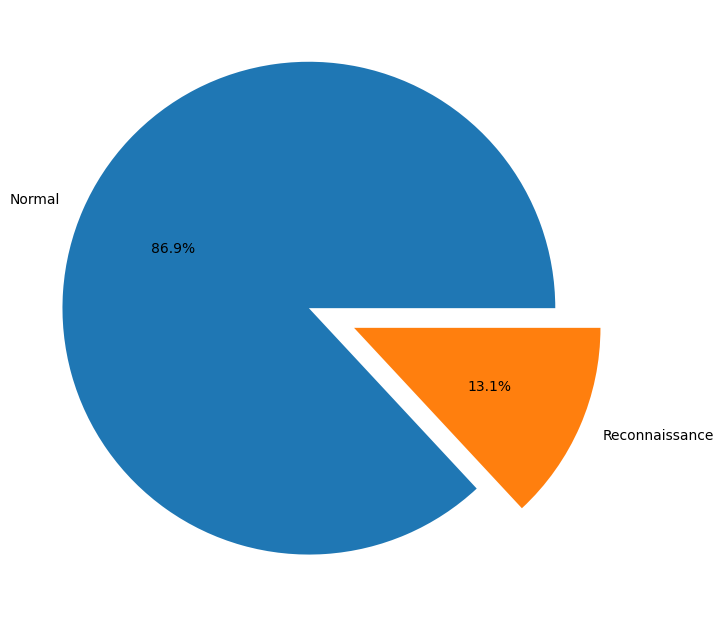

In [19]:
# Get valid attacks counts, including normal
validAttacks = df['attack_cat'].value_counts()

# Exclude categories with zero counts from the pie chart
validAttacks = validAttacks[validAttacks > 0]

print(validAttacks)

# Prepare explode list with same length as validAttacks
explode = [0.1] * len(validAttacks)  # Slightly explode all slices for visibility

plt.figure(figsize=(15, 8))
plt.pie(validAttacks, labels=validAttacks.index, autopct='%1.1f%%', explode=explode)
plt.show()

0    65101
1     9789
Name: count, dtype: int64


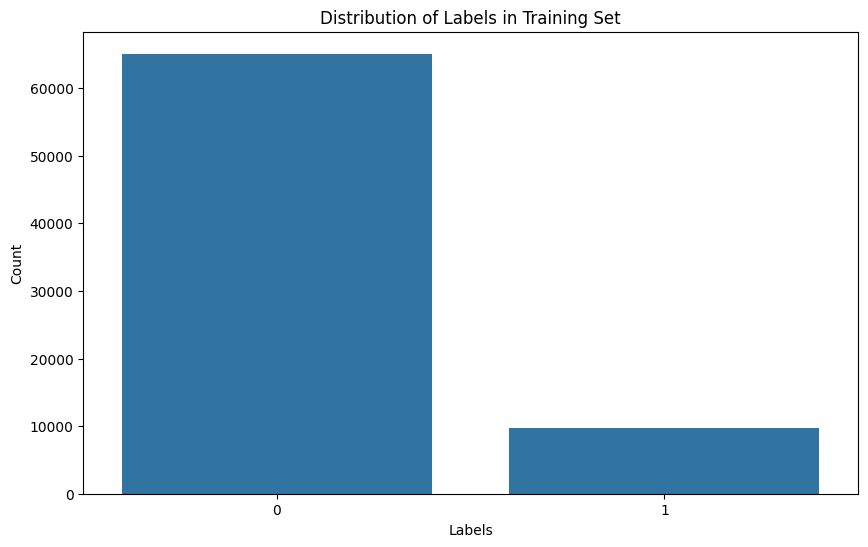

In [20]:
# Convert y_train to a pandas Series
y_train_series = pd.Series(y_train)

# Count the occurrences of each label
label_counts = y_train_series.value_counts()

print(label_counts)

# Plot the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

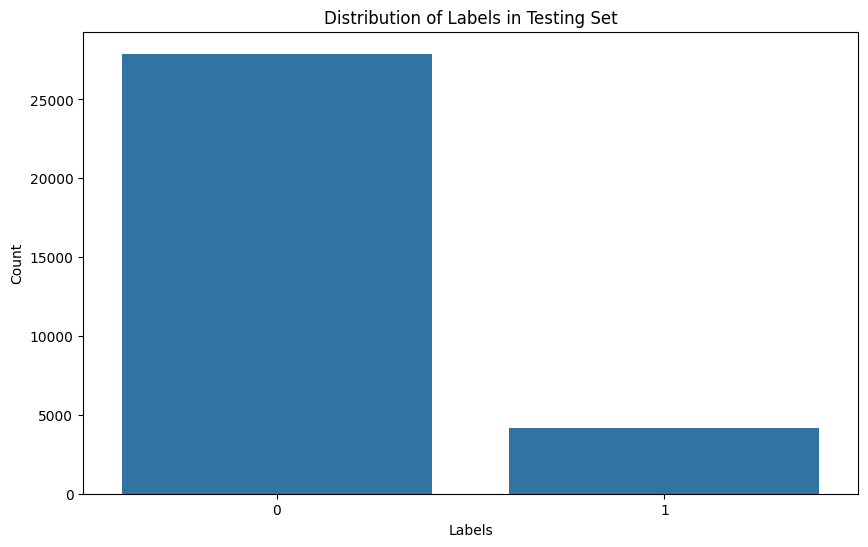

In [21]:
# Convert y_train to a pandas Series
y_test_series = pd.Series(y_test)

# Count the occurrences of each label
label_counts = y_test_series.value_counts()

# Plot the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels in Testing Set')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

# 🤖 Machine Learning

### 🌲 **Fitting a Random Forest Model and Evaluating Performance**

> In this step, I trained a **RandomForestClassifier** with 100 estimators and used it to predict the test set outcomes.

- **Model Accuracy**: I calculated the overall accuracy to assess how well the model is performing.
- **Classification Report**: The detailed classification report includes:
  - **Precision**: How many of the predicted positives were correct.
  - **Recall**: How many actual positives were correctly predicted.
  - **F1-Score**: The balance between precision and recall.

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((74890, 42), (74890,), (32097, 42), (32097,))

In [23]:
def model_evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')

    print("\n\n\n=================================================================================================")

    # Print the metrics
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    # Confusion matrix
    cross = pd.crosstab(pd.Series(y_test, name='Actual'),
                        pd.Series(y_pred, name='Predicted'))

    # Calculate percentages
    cross_percent = (cross / cross.sum().sum() * 100).round(2)

    # Create annotations with both percentages and counts
    annotations = cross_percent.astype(str) + "%\n" + cross.astype(str)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cross, annot=annotations, fmt='', cmap="coolwarm", cbar=False,
                linewidths=1, linecolor='black', annot_kws={"size": 12})

    # Add labels and title
    plt.title(f'Confusion Matrix with Percentage and Counts for {type(model).__name__}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('Actual Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    return {'Recall': recall, 'Precision': precision, 'Accuracy': accuracy}

In [24]:
models = [
    LogisticRegression(max_iter=1000, random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    SVC(random_state=42),
    GradientBoostingClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    ExtraTreesClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    LGBMClassifier(),
]

results = {}




Recall: 0.8292
Precision: 0.7555
Accuracy: 0.8292


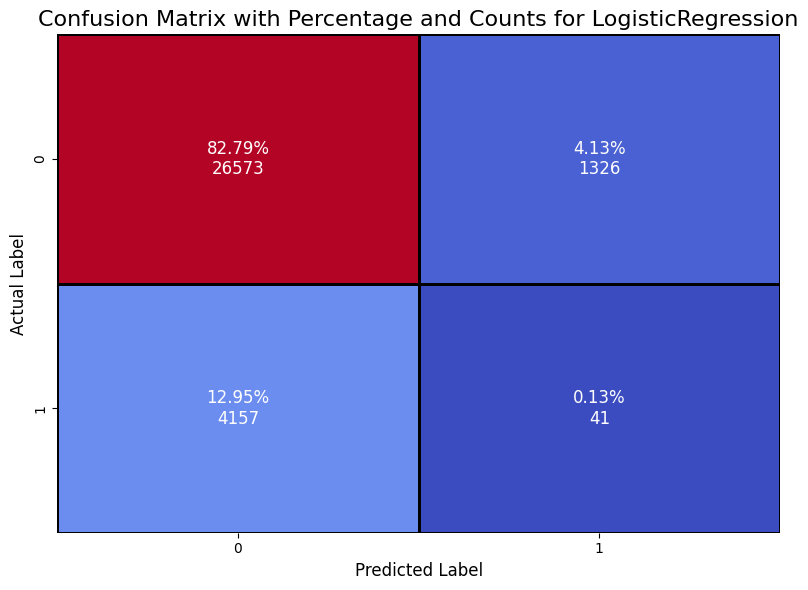




Recall: 0.9229
Precision: 0.9177
Accuracy: 0.9229


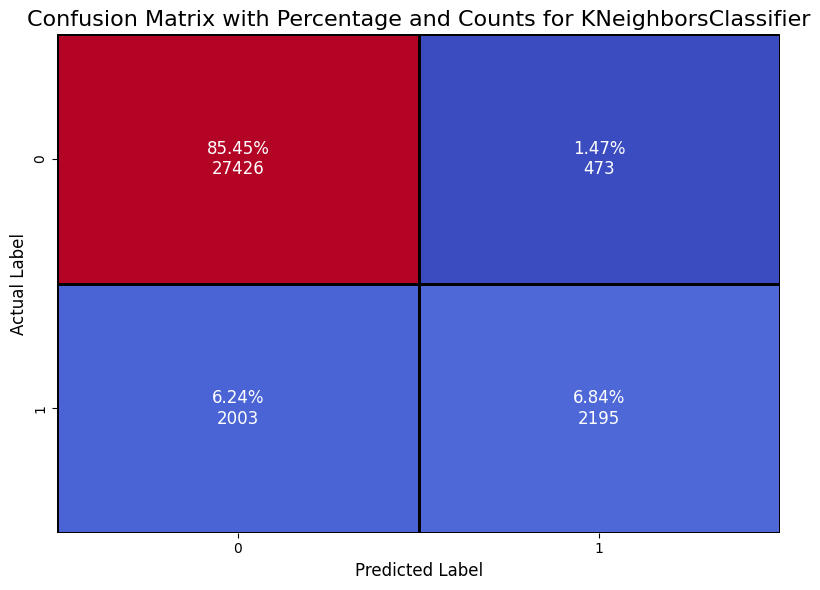




Recall: 0.9971
Precision: 0.9971
Accuracy: 0.9971


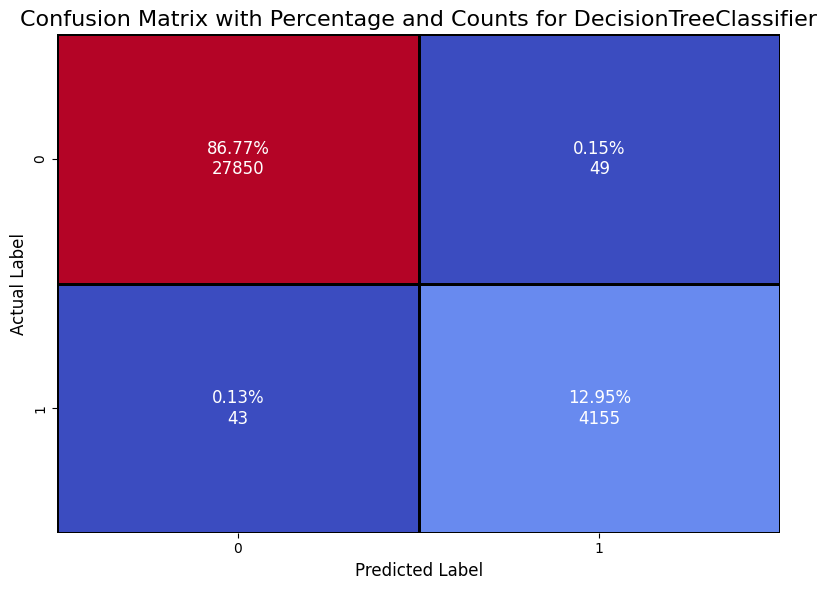




Recall: 0.9979
Precision: 0.9979
Accuracy: 0.9979


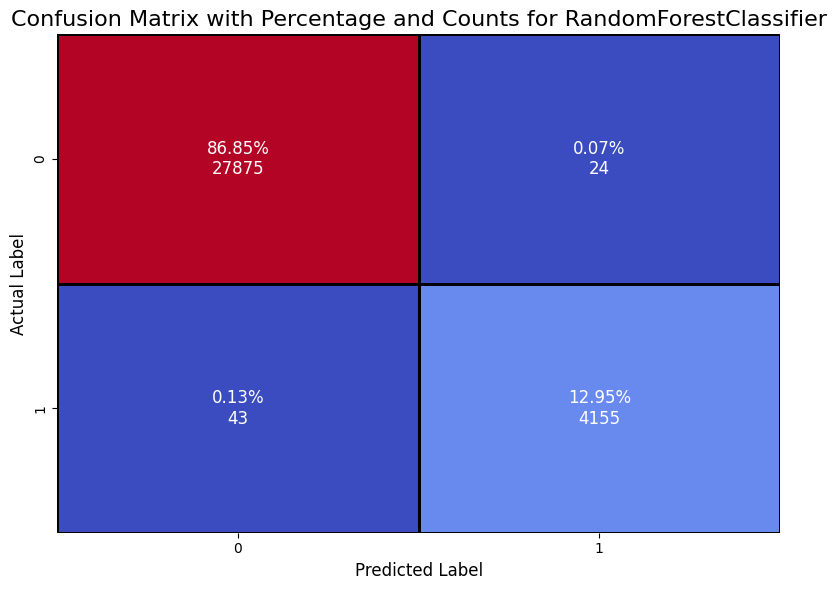




Recall: 0.8692
Precision: 0.7555
Accuracy: 0.8692


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


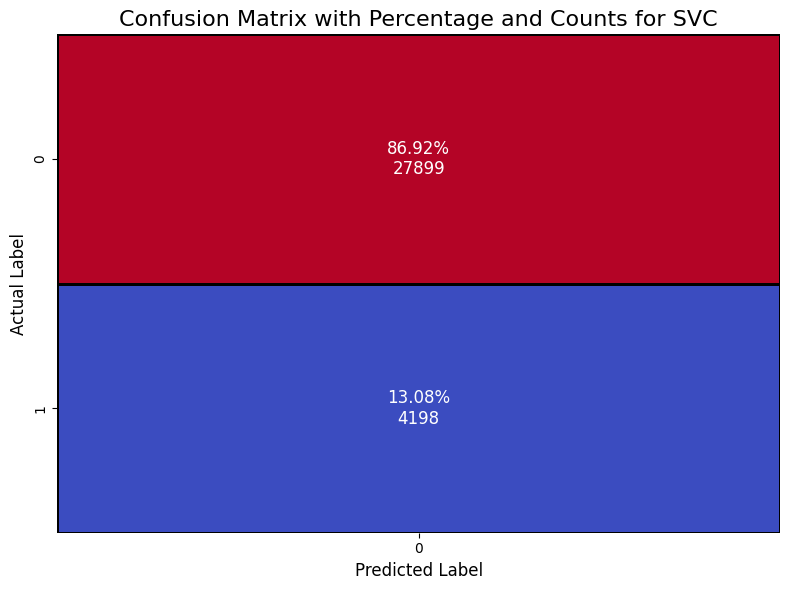




Recall: 0.9968
Precision: 0.9968
Accuracy: 0.9968


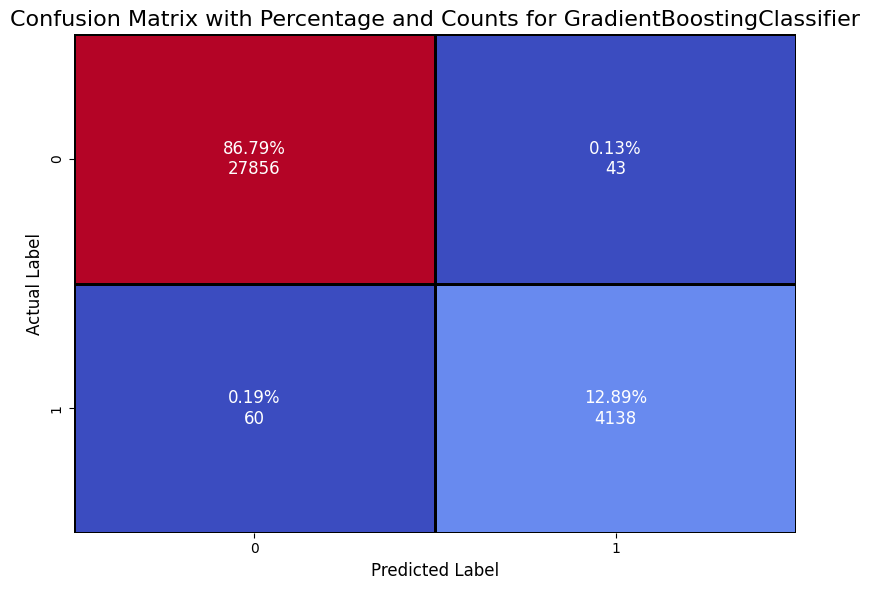

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.





Recall: 0.9945
Precision: 0.9945
Accuracy: 0.9945


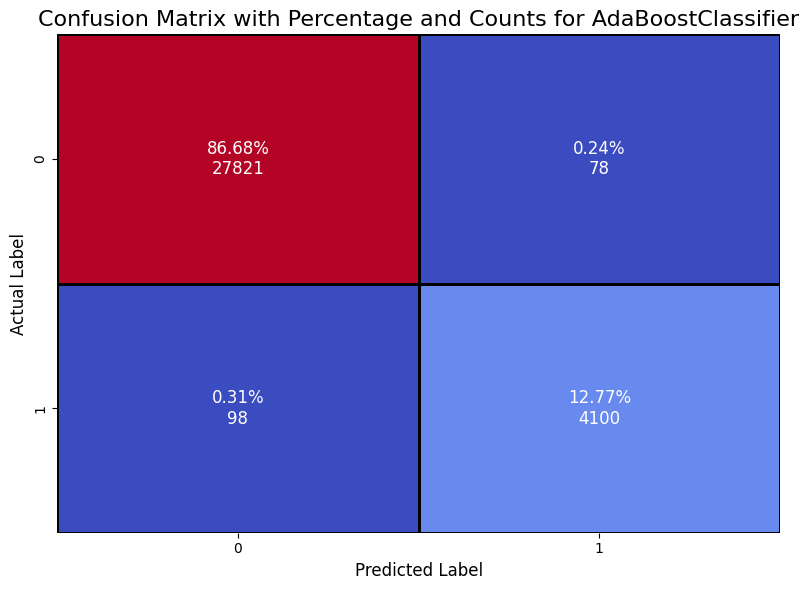




Recall: 0.5582
Precision: 0.8987
Accuracy: 0.5582


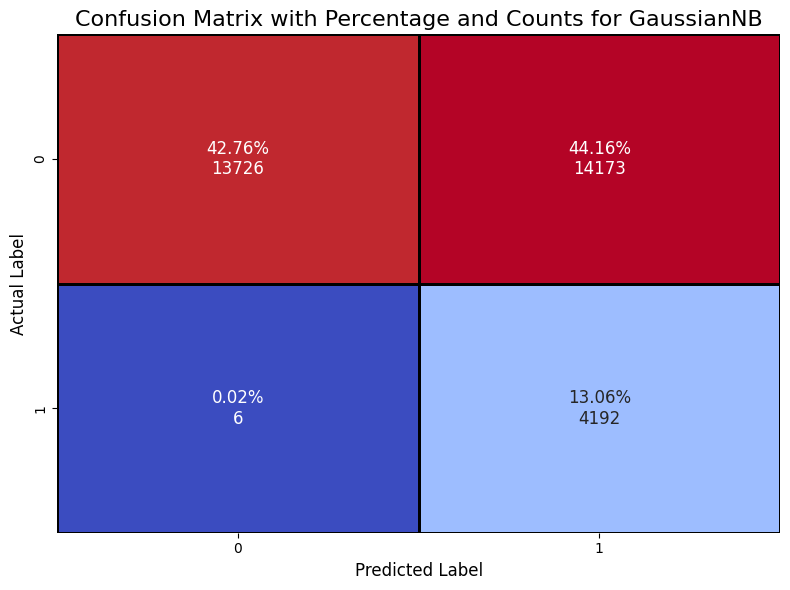




Recall: 0.9186
Precision: 0.9156
Accuracy: 0.9186


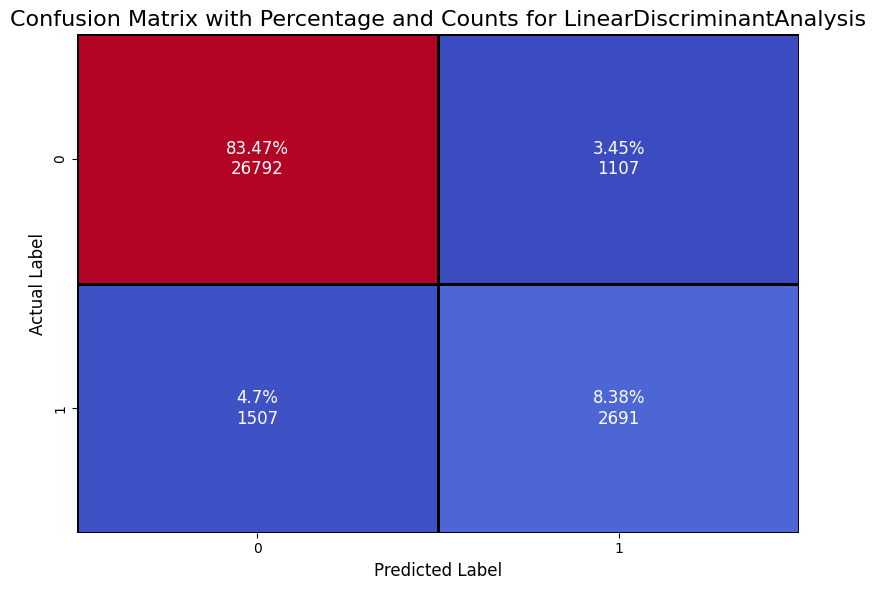

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear





Recall: 0.8656
Precision: 0.9313
Accuracy: 0.8656


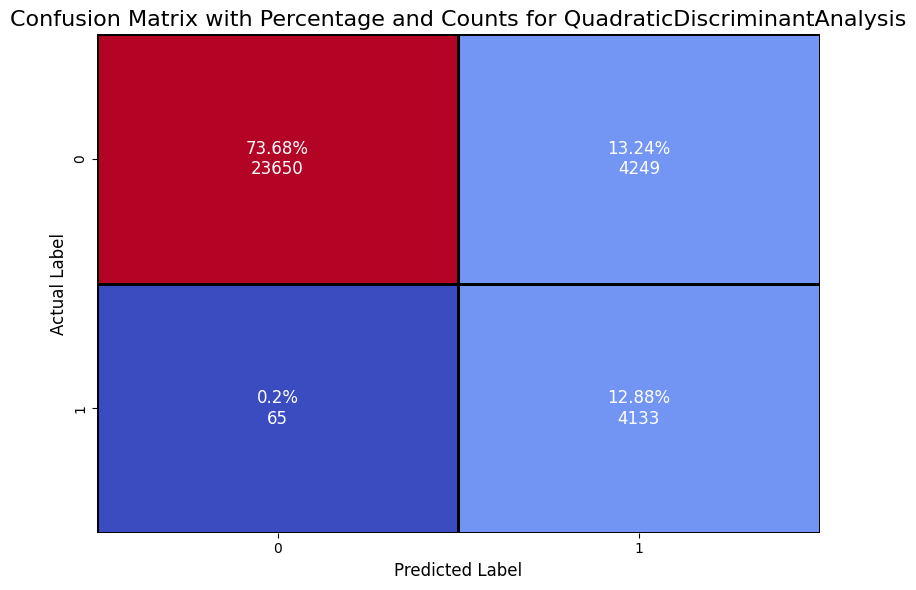




Recall: 0.9973
Precision: 0.9973
Accuracy: 0.9973


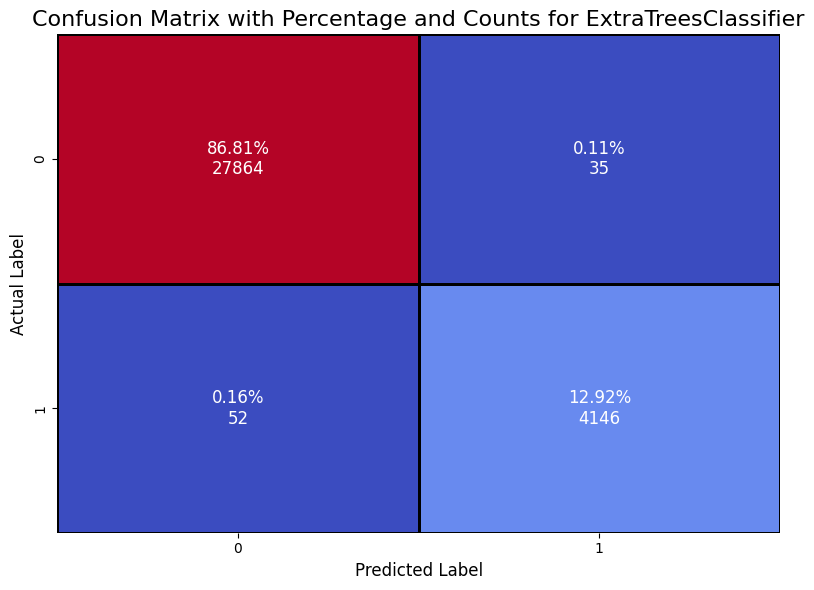




Recall: 0.9981
Precision: 0.9981
Accuracy: 0.9981


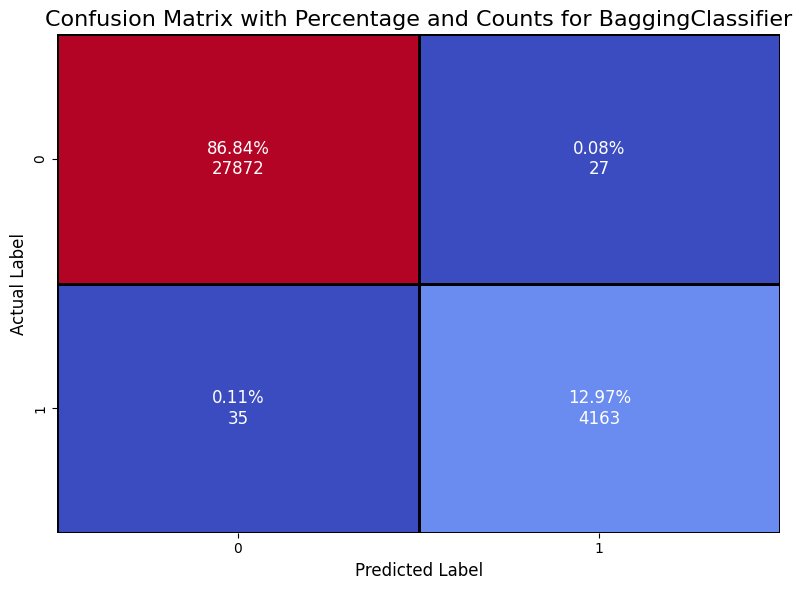

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:01:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.






Recall: 0.9983
Precision: 0.9983
Accuracy: 0.9983


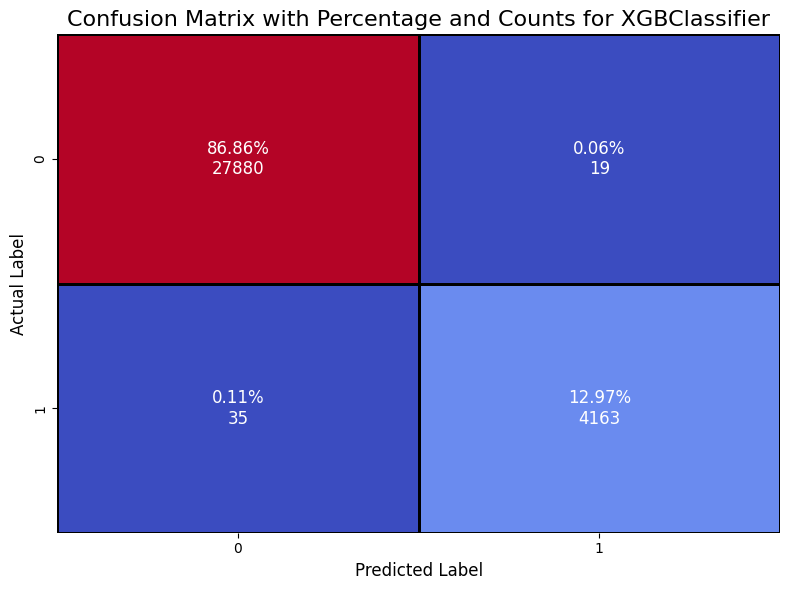

[LightGBM] [Info] Number of positive: 9789, number of negative: 65101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5407
[LightGBM] [Info] Number of data points in the train set: 74890, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130712 -> initscore=-1.894681
[LightGBM] [Info] Start training from score -1.894681



Recall: 0.9980
Precision: 0.9980
Accuracy: 0.9980


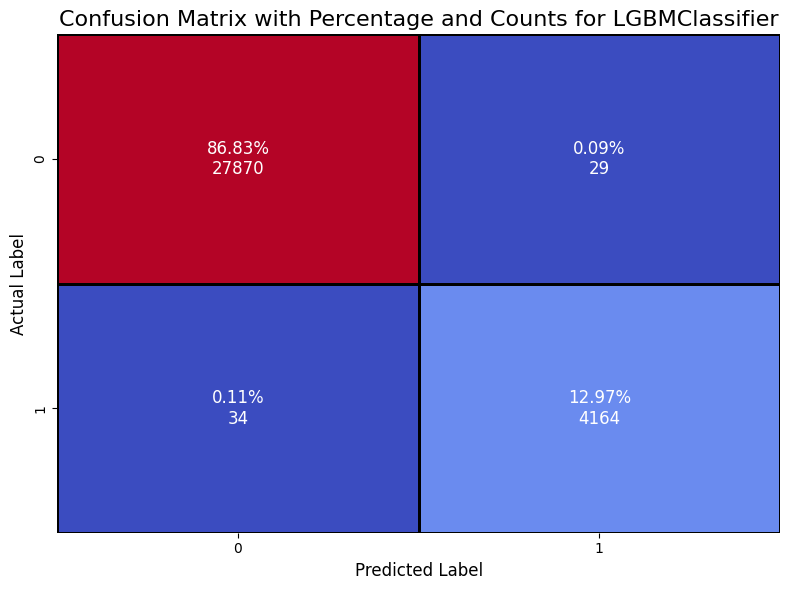

In [25]:
for model in models:
  results[model] = model_evaluation(model)

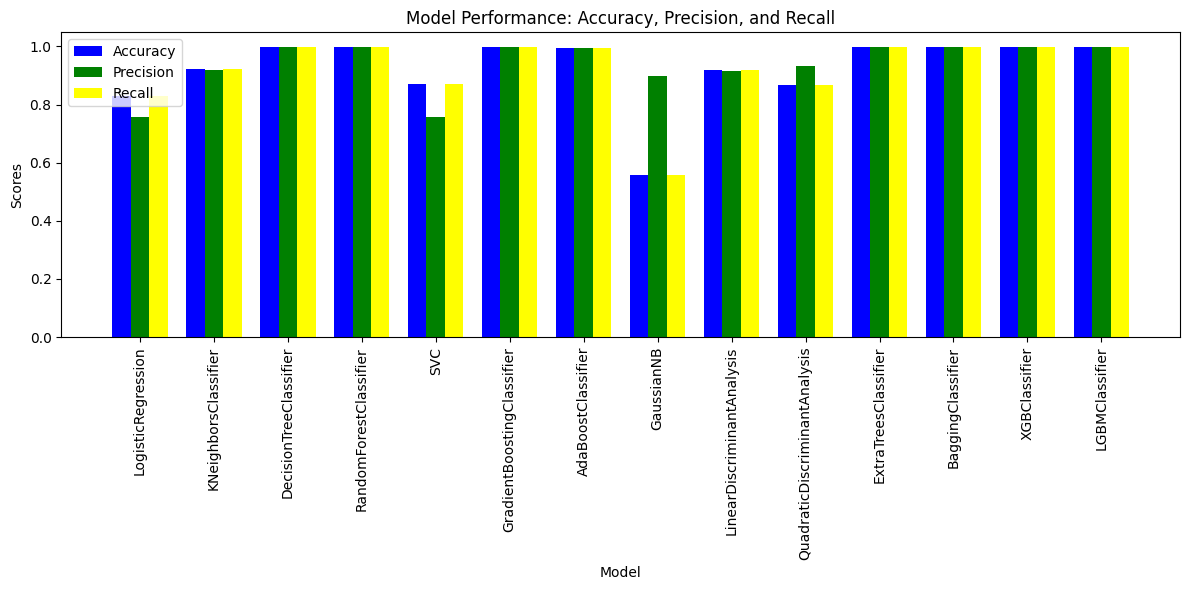

In [26]:
# Extracting model names, accuracies, precisions, and recalls
model_names = []
accuracies = []
precisions = []
recalls = []

for model, metrics in results.items():
    model_names.append(type(model).__name__)
    accuracies.append(metrics['Accuracy'])
    precisions.append(metrics['Precision'])
    recalls.append(metrics['Recall'])

# Setting the bar width and positions
bar_width = 0.25
x = np.arange(len(model_names))

# Creating the grouped bar chart
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width, accuracies, width=bar_width, label='Accuracy', color='blue')
plt.bar(x, precisions, width=bar_width, label='Precision', color='green')
plt.bar(x + bar_width, recalls, width=bar_width, label='Recall', color='yellow')

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Performance: Accuracy, Precision, and Recall')
plt.xticks(x, model_names, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# ❗️ Visualising and inspecting feature importance

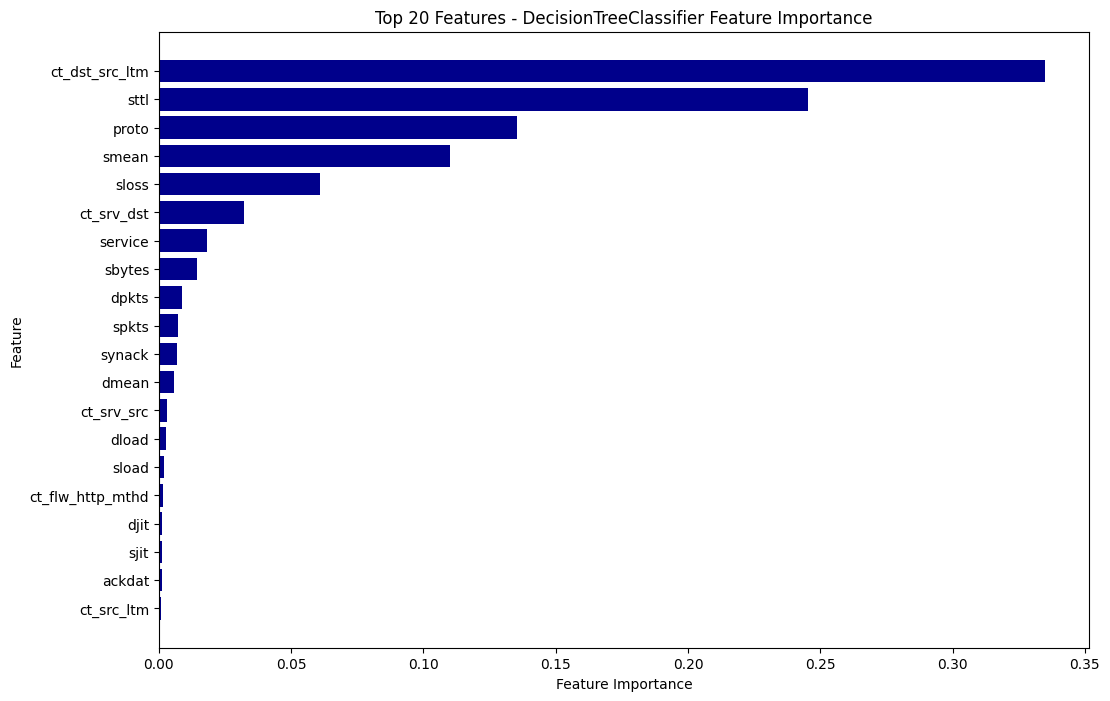

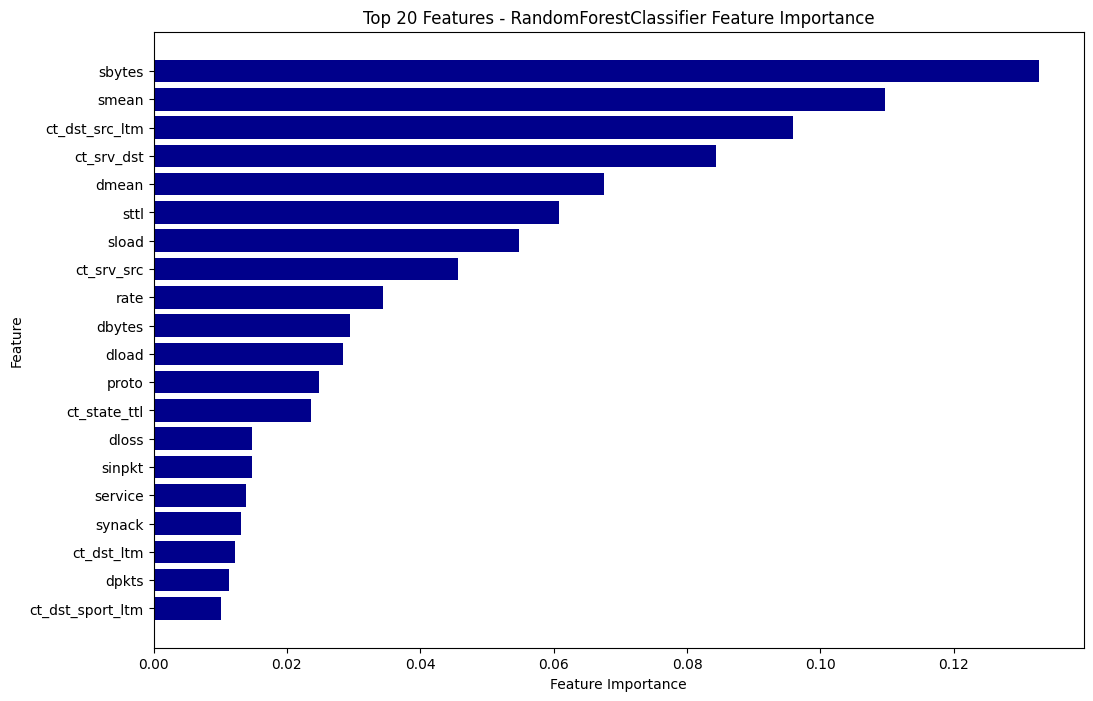

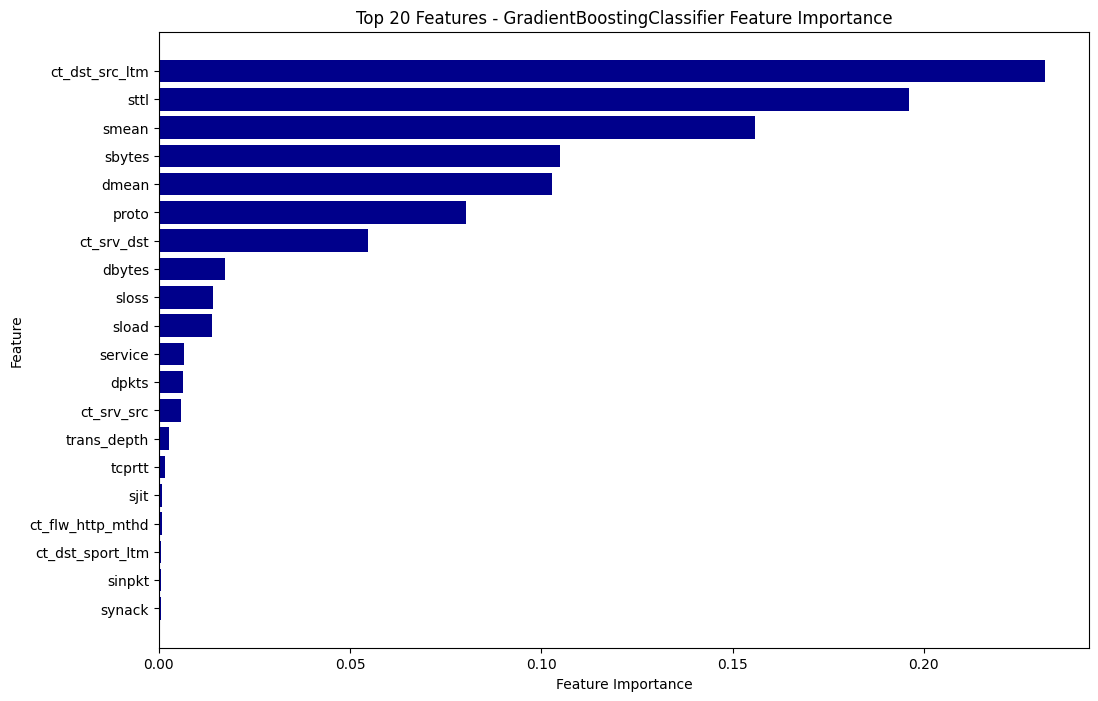

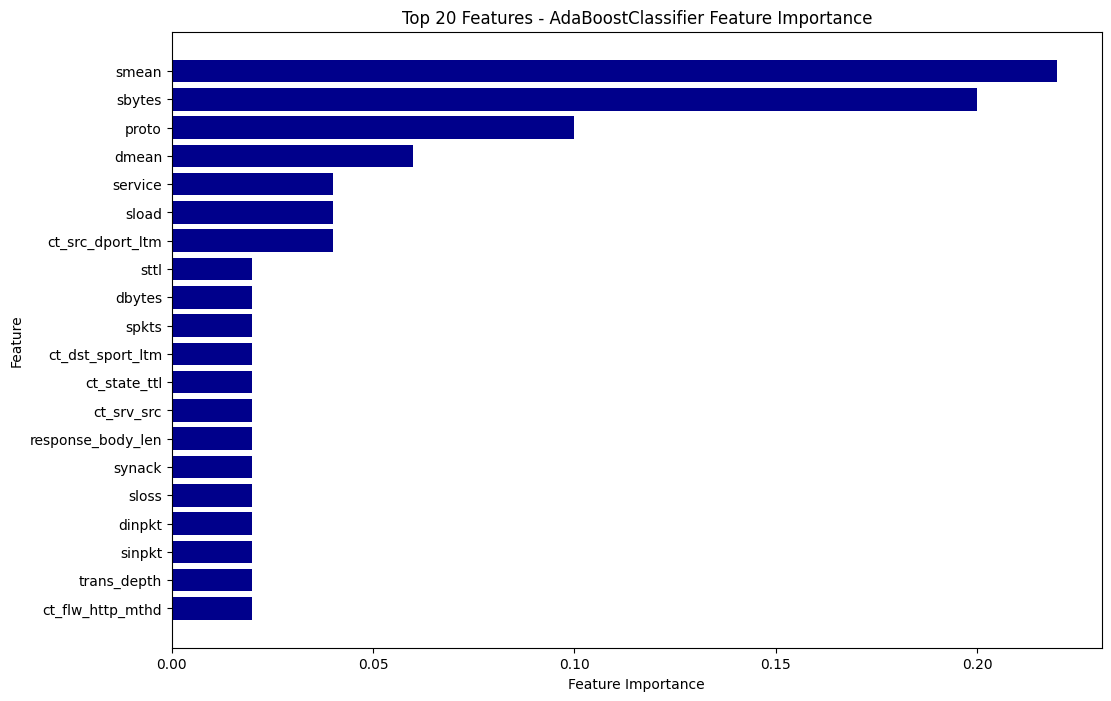

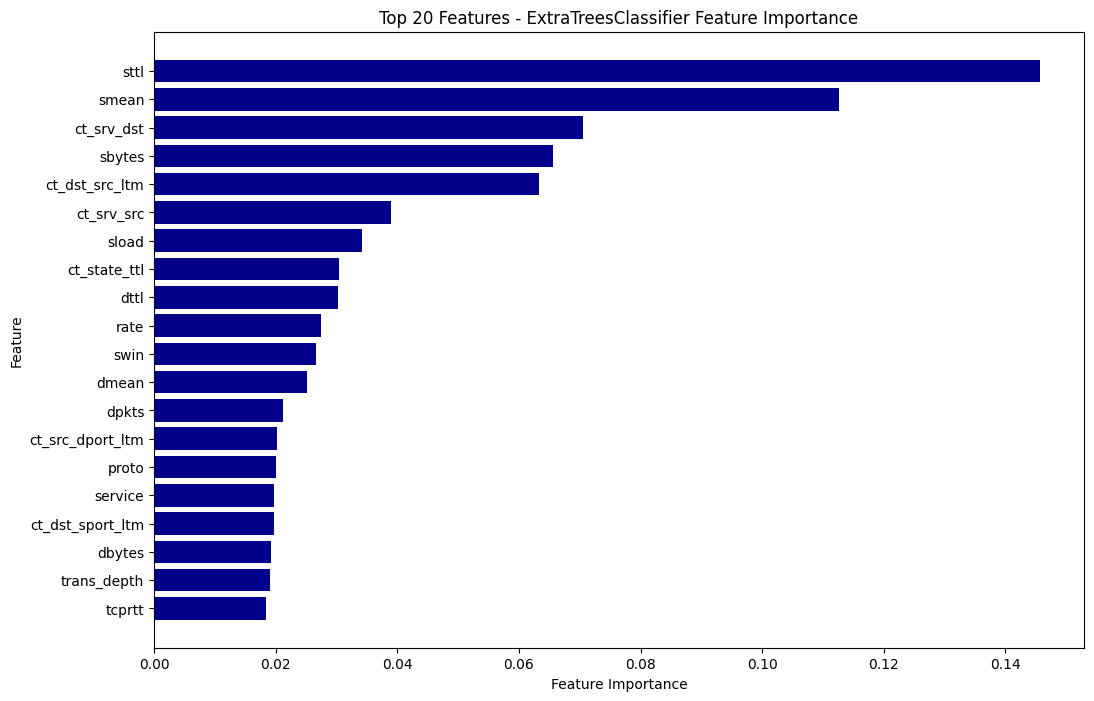

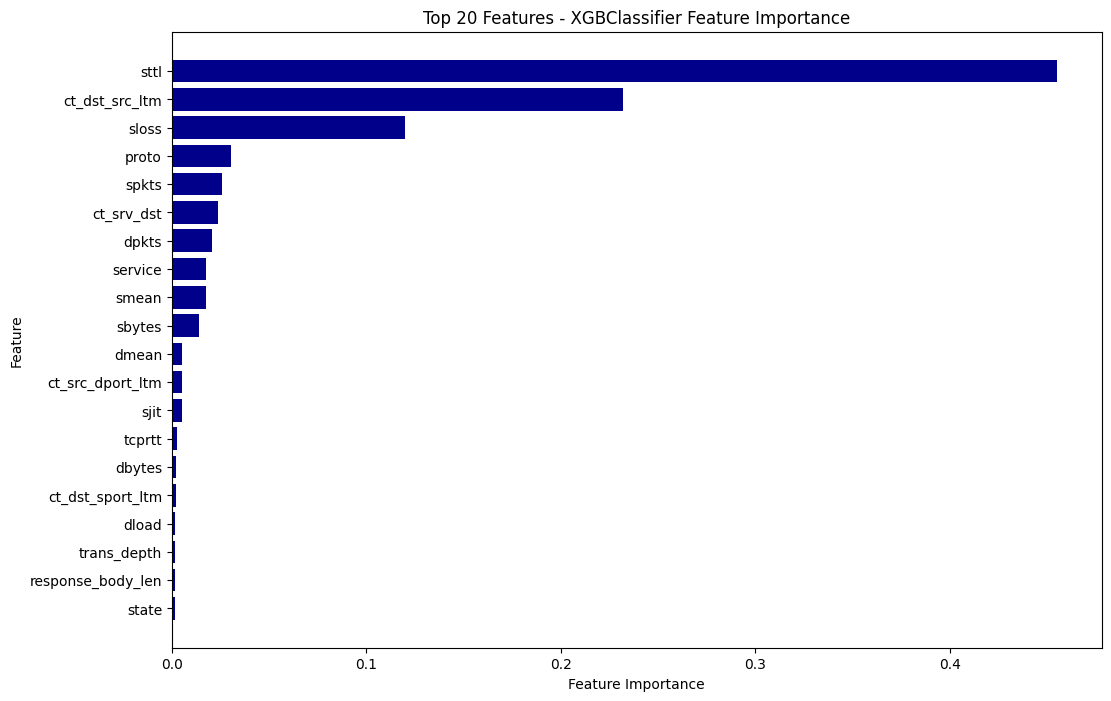

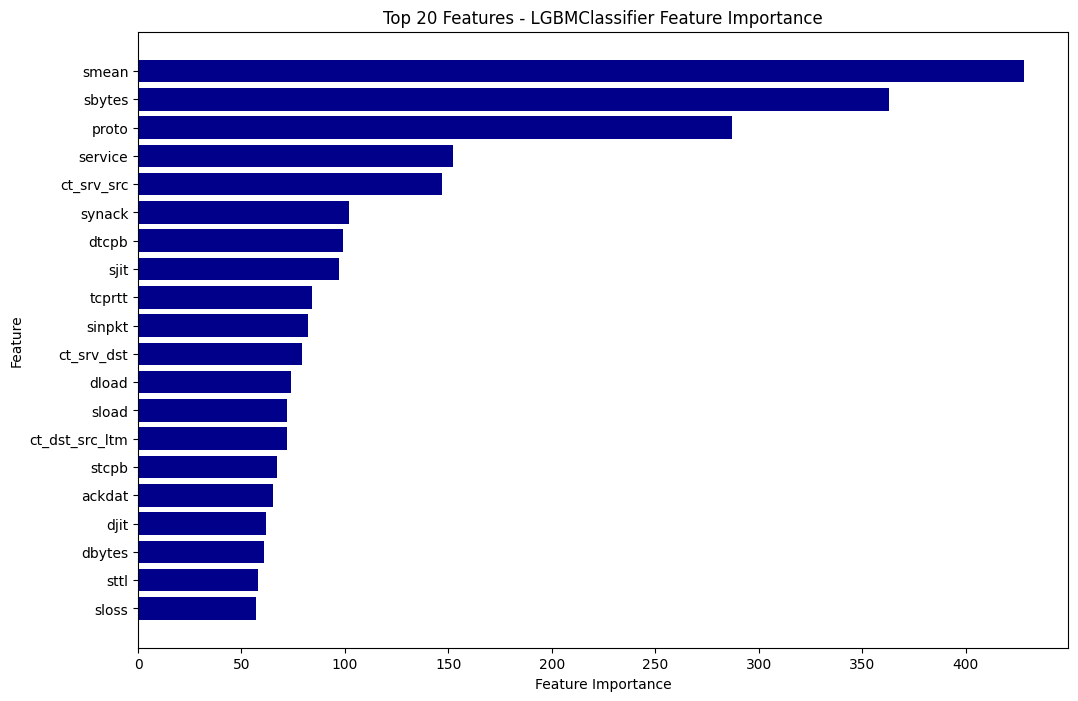

In [27]:
for model in models:
  try:
    # Get feature names
    feature_names = list(X.columns)

    # Get feature importances
    importances = model.feature_importances_

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    top_n = 20
    top_features = feature_importance_df.head(top_n)

    # Plot the top features
    plt.figure(figsize=(12, 8))
    plt.barh(top_features['Feature'], top_features['Importance'], color='darkblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Features - {type(model).__name__} Feature Importance')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
    plt.show()
  except Exception as e:
    continue

In [28]:
# Extract feature importances into a dictionary and sort
feature_importances = dict(zip(X.columns, models[3].feature_importances_))
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Create DataFrame from sorted importances
feature_imp_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])

# Apply gradient and display top 10 important features
feature_imp_df.head(10).style.background_gradient()

,Feature,Importance
0,sbytes,0.132812
1,smean,0.109741
2,ct_dst_src_ltm,0.095899
3,ct_srv_dst,0.084297
4,dmean,0.067487
5,sttl,0.060867
6,sload,0.054860
7,ct_srv_src,0.045603
8,rate,0.034398
9,dbytes,0.029504


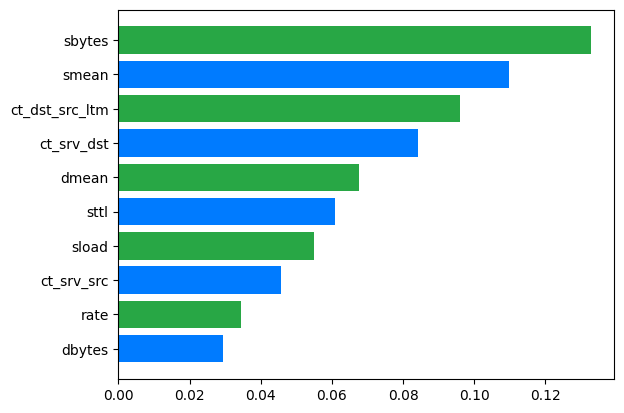

In [29]:
# Plot top 10 important features
top_10_features = feature_imp_df['Feature'][:10]
top_10_importances = feature_imp_df['Importance'][:10]
plt.barh(top_10_features, top_10_importances, color=['#28a745', '#007bff'] * 5)
plt.gca().invert_yaxis()
plt.show()

In [30]:
# Select top 10 features and create a new dataset
top_10_features = feature_imp_df['Feature'][:10].values
X_top10 = df[top_10_features]
y_top10 = df['label'].to_numpy()

In [31]:
X_top10.head()

,sbytes,smean,ct_dst_src_ltm,ct_srv_dst,dmean,sttl,sload,ct_srv_src,rate,dbytes
0,258,43,1,1,43,252,14158.942380,1,74.087490,172
1,734,52,2,6,1106,62,8395.112305,43,78.473372,42014
2,364,46,3,6,824,62,1572.271851,7,14.170161,13186
3,628,52,3,1,64,62,2740.178955,1,13.677108,770
4,534,53,40,39,45,254,8561.499023,43,33.373826,268


In [32]:
print(y_top10)

[0 0 0 ... 0 0 0]


0    93000
1    13987
Name: count, dtype: int64


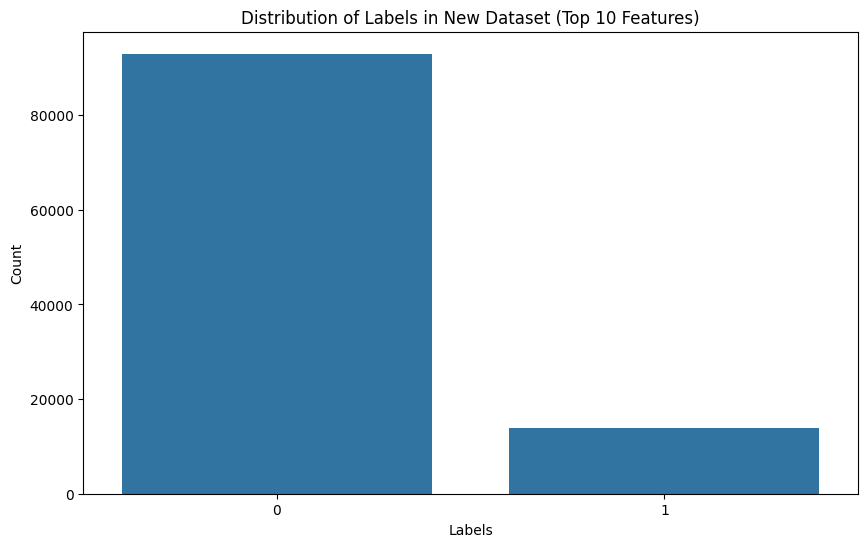

In [33]:
y_top10_series = pd.Series(y_top10)

# Count occurrences of each label
label_counts = y_top10_series.value_counts()

# Print the label counts
print(label_counts)

# Plot the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index.astype(str), y=label_counts.values)
plt.title('Distribution of Labels in New Dataset (Top 10 Features)')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [34]:
# Create the new features and labels for balanced dataset
X = df[top_10_features]
y = df['label'].to_numpy()

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [35]:
top10_results = {}




Recall: 0.8739
Precision: 0.8627
Accuracy: 0.8739


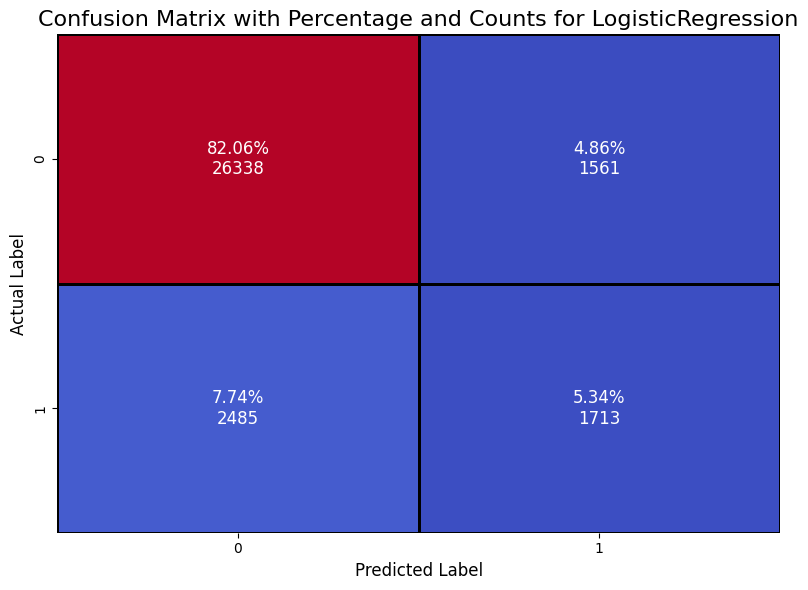




Recall: 0.9811
Precision: 0.9813
Accuracy: 0.9811


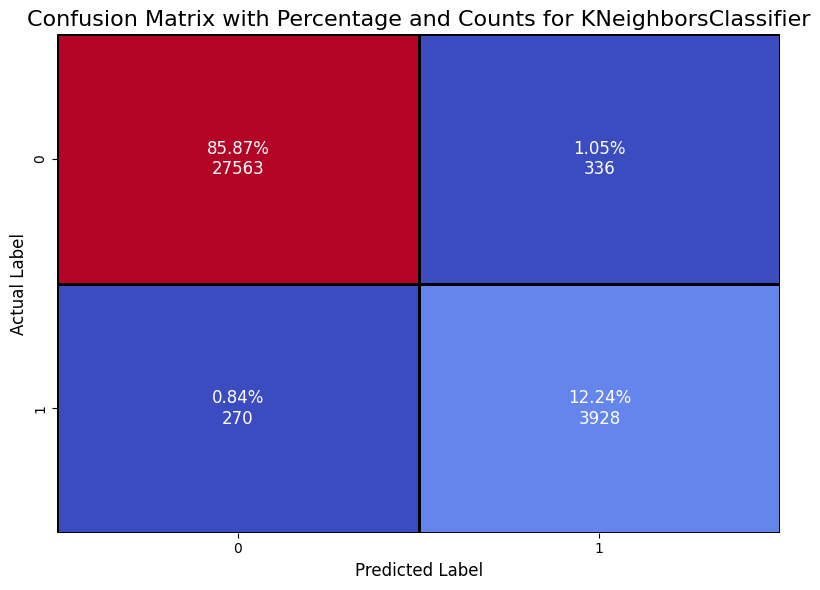




Recall: 0.9945
Precision: 0.9945
Accuracy: 0.9945


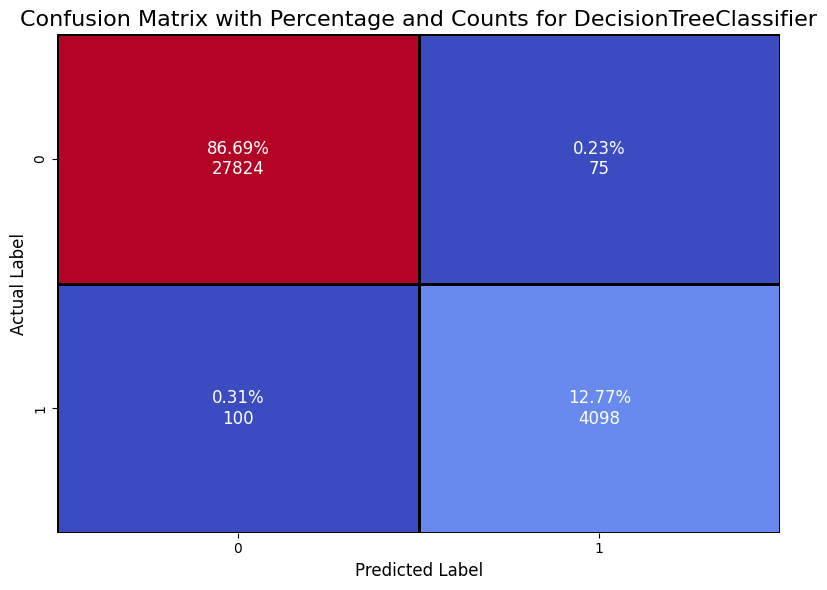




Recall: 0.9952
Precision: 0.9952
Accuracy: 0.9952


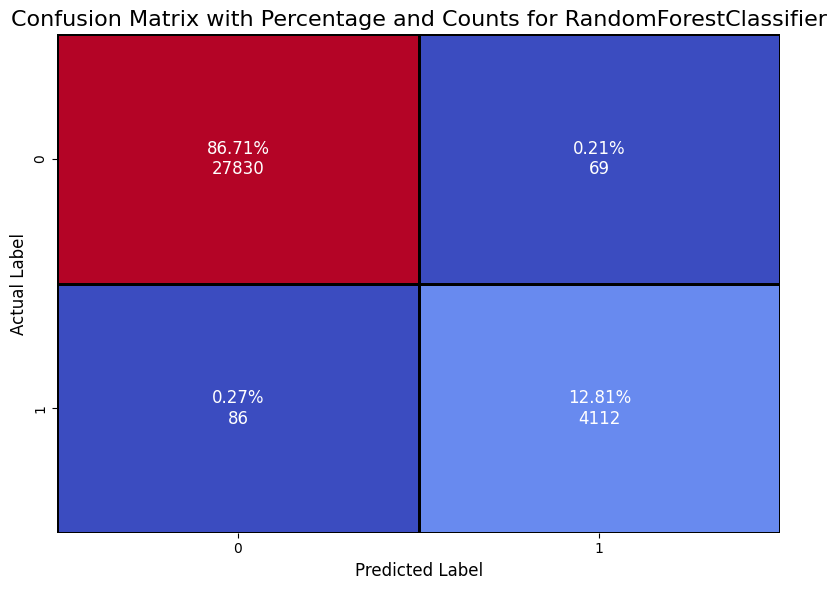




Recall: 0.9006
Precision: 0.8890
Accuracy: 0.9006


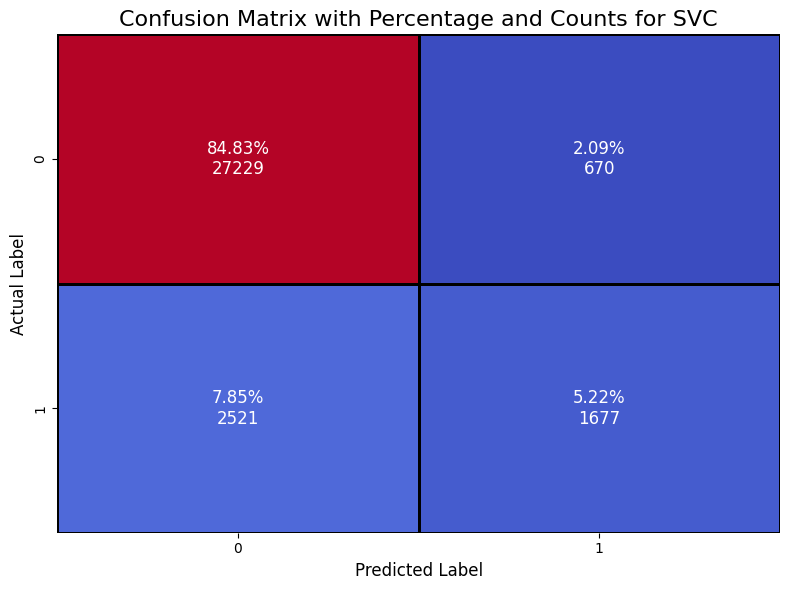




Recall: 0.9933
Precision: 0.9933
Accuracy: 0.9933


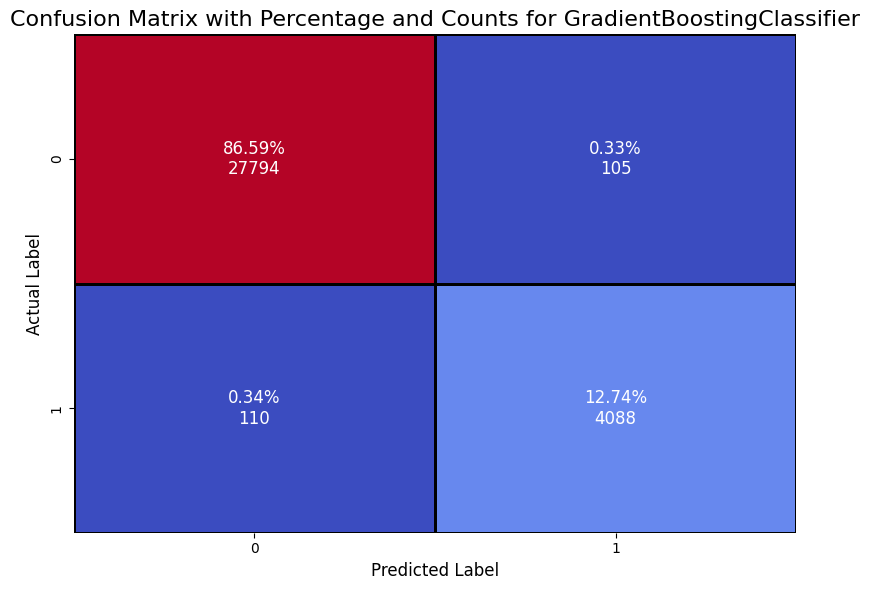

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.





Recall: 0.9897
Precision: 0.9897
Accuracy: 0.9897


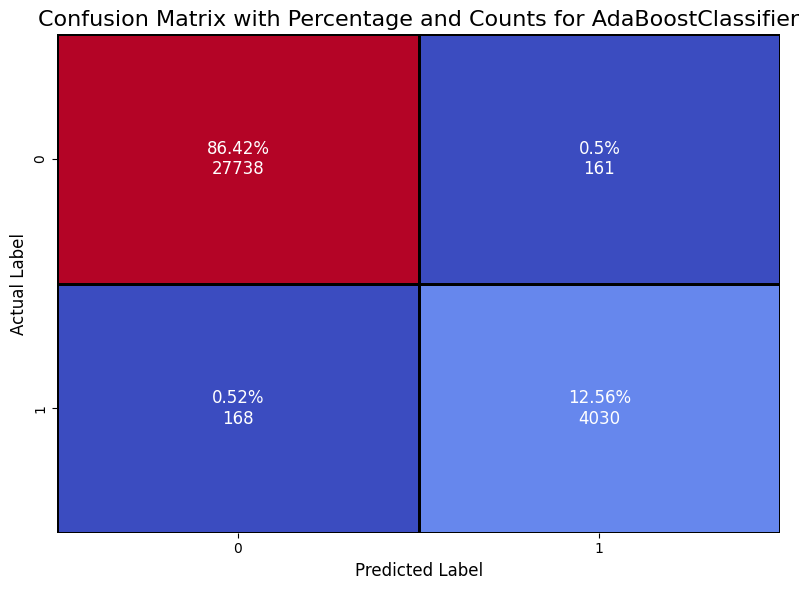




Recall: 0.8735
Precision: 0.8448
Accuracy: 0.8735


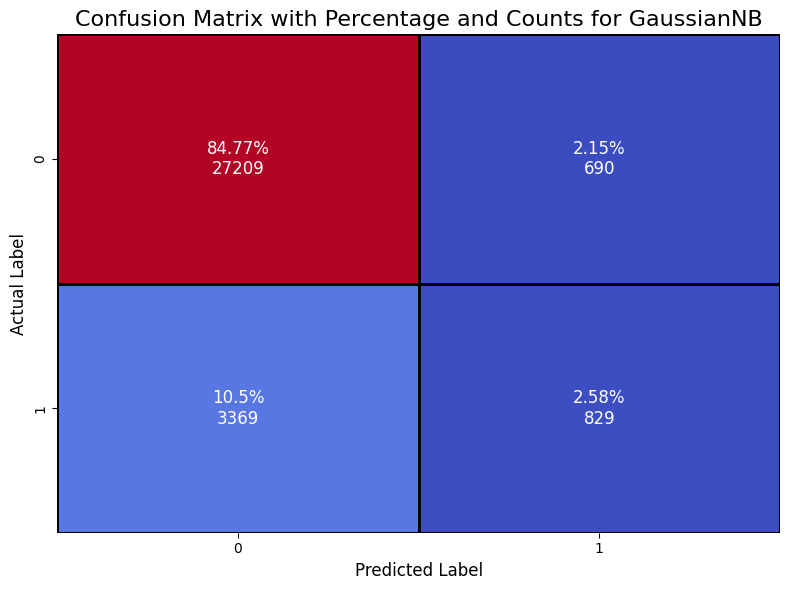




Recall: 0.9351
Precision: 0.9384
Accuracy: 0.9351


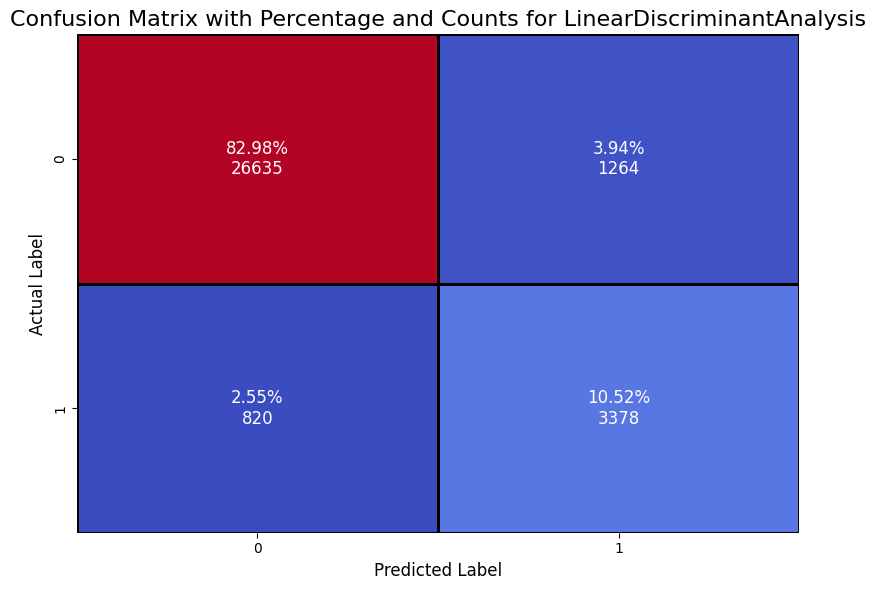




Recall: 0.8548
Precision: 0.9263
Accuracy: 0.8548


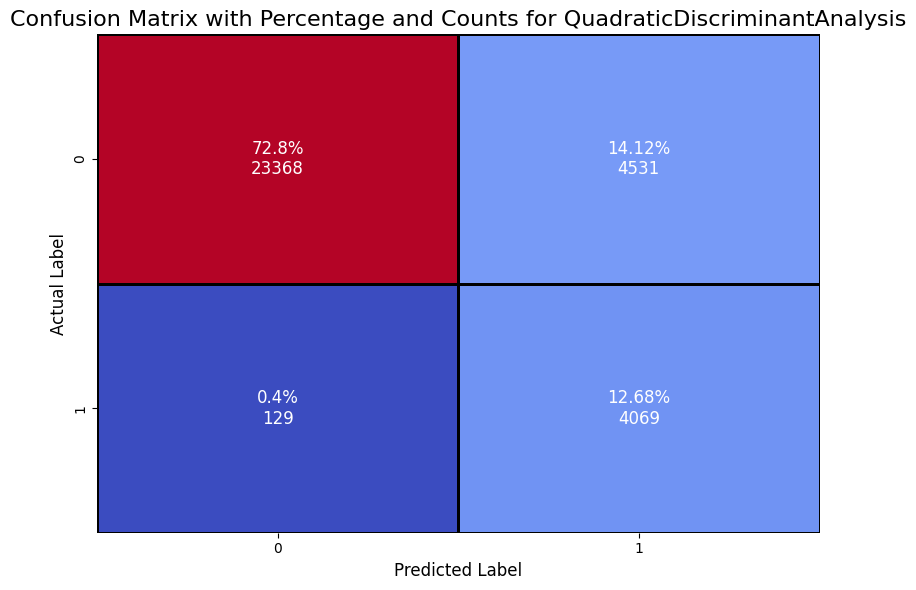




Recall: 0.9946
Precision: 0.9946
Accuracy: 0.9946


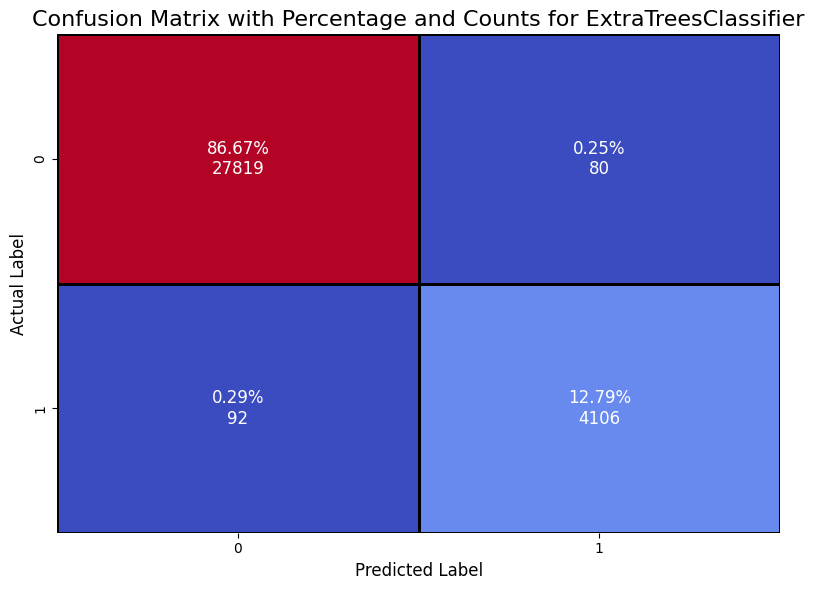




Recall: 0.9949
Precision: 0.9949
Accuracy: 0.9949


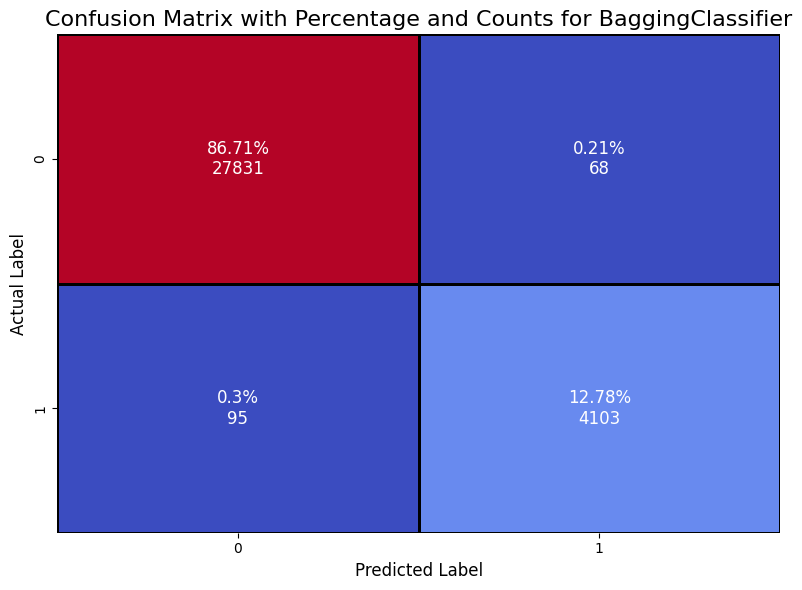

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:04:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.






Recall: 0.9952
Precision: 0.9952
Accuracy: 0.9952


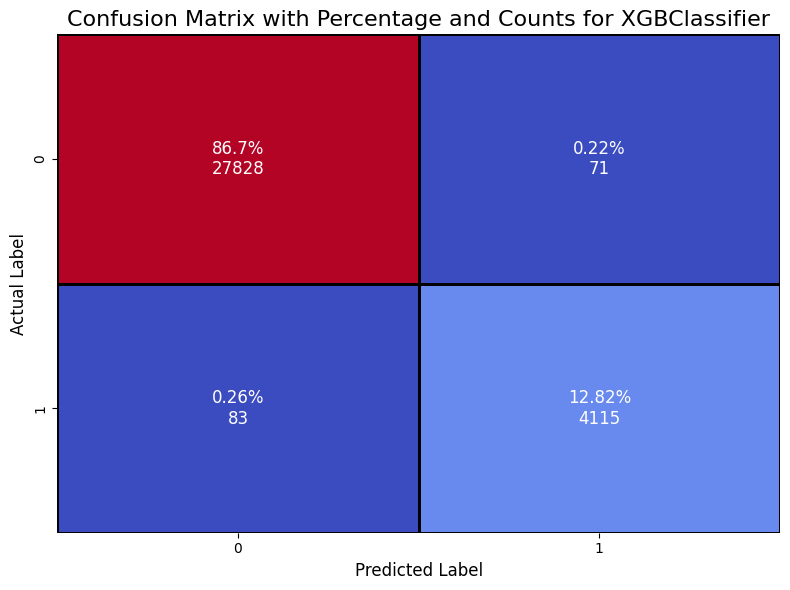

[LightGBM] [Info] Number of positive: 9789, number of negative: 65101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1624
[LightGBM] [Info] Number of data points in the train set: 74890, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130712 -> initscore=-1.894681
[LightGBM] [Info] Start training from score -1.894681



Recall: 0.9949
Precision: 0.9949
Accuracy: 0.9949


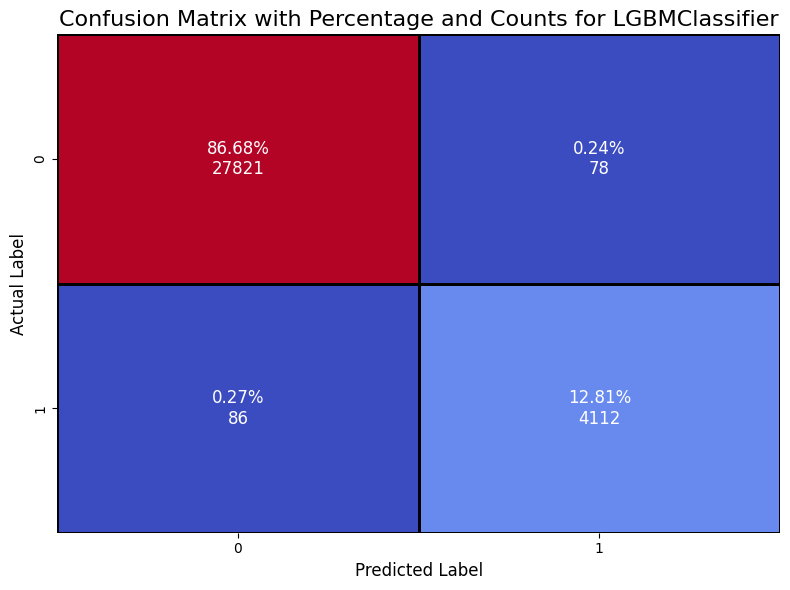

In [36]:
for model in models:
  top10_results[model] = model_evaluation(model)

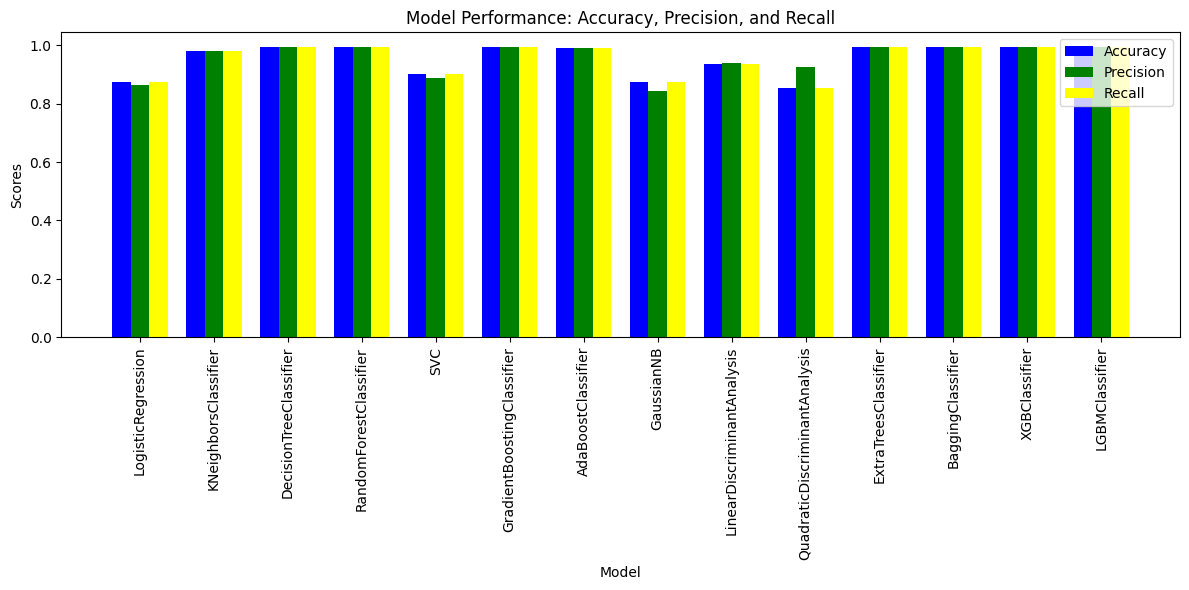

In [37]:
# Extracting model names, accuracies, precisions, and recalls
model_names = []
accuracies = []
precisions = []
recalls = []

for model, metrics in top10_results.items():
    model_names.append(type(model).__name__)
    accuracies.append(metrics['Accuracy'])
    precisions.append(metrics['Precision'])
    recalls.append(metrics['Recall'])

# Setting the bar width and positions
bar_width = 0.25
x = np.arange(len(model_names))

# Creating the grouped bar chart
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width, accuracies, width=bar_width, label='Accuracy', color='blue')
plt.bar(x, precisions, width=bar_width, label='Precision', color='green')
plt.bar(x + bar_width, recalls, width=bar_width, label='Recall', color='yellow')

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Performance: Accuracy, Precision, and Recall')
plt.xticks(x, model_names, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# ⨋ Summary

### 💾 Saving model

In [38]:
# import joblib

# # Save the model to a file
# model_filename = 'recondet_model.joblib'
# joblib.dump(rf_top10_model_ft, model_filename)